# Perform Random Forest Analysis on acoustic measures

Input large df with acoustic measures for each vowel in each word and output feature importance.

In [2]:
import pandas as pd
import numpy as np
from numpy import mean
from numpy import std
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold as kfold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import matplotlib.cbook as cbook

In [14]:
df = pd.read_csv("data/data_bigPCA.csv")
df.head()

,spec_dur,f0_creak,vowel_periph,Filename,Label,partID,Language,t1_wd,t2_wd,stress
0,-2.082444,1.975650,-0.034866,afs116_catala_exp2_a.mat,i,afs116,cat,5.502012,6.2491,0
1,4.574169,3.367846,0.112931,afs116_catala_exp2_a.mat,a,afs116,cat,5.502012,6.2491,1
2,3.266917,2.909851,1.798889,afs116_catala_exp2_a.mat,i,afs116,cat,10.850600,12.0906,0
3,5.502514,3.287845,0.004191,afs116_catala_exp2_a.mat,a,afs116,cat,10.850600,12.0906,1
4,4.762114,2.906207,1.791195,afs116_catala_exp2_a.mat,i,afs116,cat,40.617489,42.1002,0


In [15]:
df_1 = df[(df['Label']=="i") | (df['Label']=="pen")].copy()
df_2 = df[(df['Label']!="i") & (df['Label']!="pen")].copy()

In [16]:
df_wd = pd.merge(df_1, df_2, on=['Filename', 't1_wd', 't2_wd', 'partID', 'Language'],
                 suffixes=('_vowel1', '_vowel2'))

Label row as `Paroxytone` if vowel 1 is stressed and `Oxytone` if vowel 2 is stressed.

In [17]:
df_wd['stress_wd'] = np.where(df_wd['stress_vowel1']==1, 'Paroxytone', 'Oxytone')

In [18]:
df_wd['f0_creak_ratio'] = df_wd['f0_creak_vowel1']/df_wd['f0_creak_vowel2']
df_wd['spec_dur_ratio'] = df_wd['spec_dur_vowel1']/df_wd['spec_dur_vowel2']
df_wd['vowel_periph_ratio'] = df_wd['vowel_periph_vowel1']/df_wd['vowel_periph_vowel2']

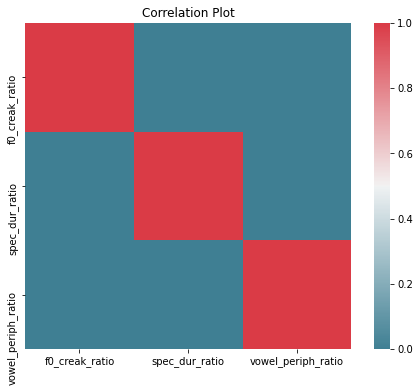

In [19]:
subset = df_wd.drop(['t1_wd', 't2_wd', 'stress_vowel1', 'stress_vowel2', 'f0_creak_vowel1', 'f0_creak_vowel2',
                    'spec_dur_vowel1', 'spec_dur_vowel2', 'vowel_periph_vowel1', 'vowel_periph_vowel2'],
                    axis = 1)
cor= subset.corr(method='pearson')
fig, ax =plt.subplots(figsize=(8, 6))
plt.title("Correlation Plot")
sns.heatmap(cor, mask=np.zeros_like(cor, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)
plt.show()

New column for vowel duration ratio, new column for syllable duration ratio, new column for Delta F distance from center calculation, new column for energy ratio.

In [20]:
df_wd.columns

Index(['spec_dur_vowel1', 'f0_creak_vowel1', 'vowel_periph_vowel1', 'Filename',
       'Label_vowel1', 'partID', 'Language', 't1_wd', 't2_wd', 'stress_vowel1',
       'spec_dur_vowel2', 'f0_creak_vowel2', 'vowel_periph_vowel2',
       'Label_vowel2', 'stress_vowel2', 'stress_wd', 'f0_creak_ratio',
       'spec_dur_ratio', 'vowel_periph_ratio'],
      dtype='object')

In [21]:
df_wd.drop(['Filename', 't1_wd', 't2_wd', 'Label_vowel1', 'Label_vowel2', 'stress_vowel1', 'stress_vowel2',
           'f0_creak_vowel1', 'f0_creak_vowel2', 'spec_dur_vowel1', 'spec_dur_vowel2',
           'vowel_periph_vowel1', 'vowel_periph_vowel2'], axis = 1,
          inplace = True)
df_wd.columns

Index(['partID', 'Language', 'stress_wd', 'f0_creak_ratio', 'spec_dur_ratio',
       'vowel_periph_ratio'],
      dtype='object')

Look for empty rows

In [22]:
df_wd.isnull().sum()

partID                0
Language              0
stress_wd             0
f0_creak_ratio        0
spec_dur_ratio        0
vowel_periph_ratio    0
dtype: int64

In [23]:
y_all = df_wd['stress_wd']
X_all = df_wd.drop(['stress_wd', 'Language', 'partID'], axis = 1)
    
rf_classifier = RandomForestClassifier(random_state = 10)
    
param_grid = { 
    'n_estimators': [500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : np.arange(4,10,1),
    'criterion' :['gini', 'entropy']
}

CV_rfc = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv= 5)
CV_rfc.fit(X_all, y_all)
    
print("Best RF Estimator: ", CV_rfc.best_params_, "\n")
    
scores = cross_val_score(rf_classifier, X_all, y_all.ravel(), cv=5)
print("Accuracy over all data: ", scores.mean())
    
rf_classifier_best = CV_rfc.best_estimator_

cols = X_all.columns

Best RF Estimator:  {'criterion': 'gini', 'max_depth': 9, 'max_features': 'auto', 'n_estimators': 500} 

Accuracy over all data:  0.5858011864544954


In [24]:
def rf(df, rf_classifier_best, cols):
    lang = []
    partid = []
    dfs = []
        
    for p in df.partID.unique():
        data = df[df['partID']==p].copy()
        
        for l in data.Language.unique():
            # isolate language of interest
            data1 = data[data['Language']==l].copy()
            data1.drop(['Language', 'partID'], axis = 1, inplace = True)
            data1.reset_index(inplace = True, drop = True)
            
            # define predictor label
            y = data1['stress_wd']

            # define feature set
            X = data1.drop(['stress_wd'], axis = 1)
            
            rf_classifier_best.fit(X, y.ravel())
            importances = rf_classifier_best.feature_importances_
            std = np.std([tree.feature_importances_ for tree in rf_classifier_best.estimators_], axis=0)
            q_25 = np.percentile([tree.feature_importances_ for tree in rf_classifier_best.estimators_], 25, axis = 0)
            q_75 = np.percentile([tree.feature_importances_ for tree in rf_classifier_best.estimators_], 75, axis = 0)
            
            # make df
            columns = ['Feature', 'Importance (MDI)', 'Std', 'q25', 'q75']
            rfs = pd.DataFrame([cols, importances, std, q_25, q_75]).transpose()
            rfs.columns = columns
            rfs['Language'] = l
            rfs['partID'] = p
            dfs.append(rfs)
        
    rf_df = pd.concat(dfs)
        
    return(rf_df)

In [25]:
rf_df = rf(df_wd, rf_classifier_best, cols)
rf_df.head()

,Feature,Importance (MDI),Std,q25,q75,Language,partID
0,f0_creak_ratio,0.324142,0.327953,0.009076,0.529199,cat,afs116
1,spec_dur_ratio,0.238624,0.274277,0.0,0.396465,cat,afs116
2,vowel_periph_ratio,0.437234,0.350261,0.0,0.730415,cat,afs116
0,f0_creak_ratio,0.319478,0.107445,0.244013,0.390022,eng,afs116
1,spec_dur_ratio,0.33933,0.114165,0.259517,0.418614,eng,afs116


Merge in BLP PCA components.

In [26]:
parts = pd.read_csv("../blp/data/parts.csv")
parts['partID'] = parts['partID'].map(str.lower)

In [27]:
rf_lang = pd.merge(rf_df, parts, on = "partID", how = "left")
rf_lang.head()

,Feature,Importance (MDI),Std,q25,q75,Language,partID,lang_profile
0,f0_creak_ratio,0.324142,0.327953,0.009076,0.529199,cat,afs116,l1_eng
1,spec_dur_ratio,0.238624,0.274277,0.0,0.396465,cat,afs116,l1_eng
2,vowel_periph_ratio,0.437234,0.350261,0.0,0.730415,cat,afs116,l1_eng
3,f0_creak_ratio,0.319478,0.107445,0.244013,0.390022,eng,afs116,l1_eng
4,spec_dur_ratio,0.33933,0.114165,0.259517,0.418614,eng,afs116,l1_eng


In [28]:
blp_pca = pd.read_csv("../blp/data/pca_blp.csv")
blp_pca.drop(['lang_profile'], axis = 1, inplace = True)

In [29]:
rf_df_blp = pd.merge(rf_lang, blp_pca, on="partID", how = "left")
rf_df_blp.sample(10)

,Feature,Importance (MDI),Std,q25,q75,Language,partID,lang_profile,pc1,pc2
161,vowel_periph_ratio,0.31598,0.117336,0.23193,0.397996,cat,arn090,l3_eng,-3.824266,0.760485
71,vowel_periph_ratio,0.294729,0.104135,0.222919,0.36598,eng,ake031,l1_eng,4.930393,-0.787288
389,vowel_periph_ratio,0.328195,0.121381,0.239674,0.407066,cat,arr030,l3_eng,-4.591304,-3.365294
275,vowel_periph_ratio,0.316277,0.203541,0.155986,0.446822,cat,lnm175,l1_eng,5.595493,-0.788494
193,spec_dur_ratio,0.336847,0.213941,0.174241,0.490423,spa,auj020,l1_eng,8.466809,4.466165
417,f0_creak_ratio,0.26716,0.132753,0.16637,0.359263,eng,elc149,l3_eng,-4.001290,-2.221333
338,vowel_periph_ratio,0.317424,0.129277,0.218991,0.407324,eng,rrr070,l3_eng,-3.845810,-0.133834
165,f0_creak_ratio,0.317399,0.126049,0.223562,0.400651,spa,arn090,l3_eng,-3.824266,0.760485
176,vowel_periph_ratio,0.275961,0.148837,0.155387,0.377102,spa,asl181,l1_eng,3.226858,-1.792924
330,f0_creak_ratio,0.32052,0.132397,0.225764,0.413983,spa,rre101,l3_eng,-4.698206,3.409553


In [30]:
rf_df_blp['Stdx2'] = rf_df_blp['Std']*2

In [31]:
rf_df_blp.to_csv("data/rf_by_parts_bigPCA.csv", index = False)

## Visualize across BLP components

In [32]:
df = pd.read_csv("data/rf_by_parts_bigPCA.csv")
df.head()

,Feature,Importance (MDI),Std,q25,q75,Language,partID,lang_profile,pc1,pc2,Stdx2
0,f0_creak_ratio,0.324142,0.327953,0.009076,0.529199,cat,afs116,l1_eng,6.165044,2.991184,0.655905
1,spec_dur_ratio,0.238624,0.274277,0.000000,0.396465,cat,afs116,l1_eng,6.165044,2.991184,0.548554
2,vowel_periph_ratio,0.437234,0.350261,0.000000,0.730415,cat,afs116,l1_eng,6.165044,2.991184,0.700522
3,f0_creak_ratio,0.319478,0.107445,0.244013,0.390022,eng,afs116,l1_eng,6.165044,2.991184,0.214889
4,spec_dur_ratio,0.339330,0.114165,0.259517,0.418614,eng,afs116,l1_eng,6.165044,2.991184,0.228331


In [33]:
eng = df[(df['Language']=="eng") & (df['lang_profile']!='mono')].copy()
eng.sample(10)

,Feature,Importance (MDI),Std,q25,q75,Language,partID,lang_profile,pc1,pc2,Stdx2
503,vowel_periph_ratio,0.321112,0.108584,0.245698,0.390007,eng,vrc053,l1_eng,6.934260,4.094739,0.217168
5,vowel_periph_ratio,0.341192,0.123854,0.247510,0.424783,eng,afs116,l1_eng,6.165044,2.991184,0.247708
52,spec_dur_ratio,0.374007,0.124414,0.288836,0.459349,eng,aei079,l1_eng,4.173198,2.576465,0.248828
409,spec_dur_ratio,0.319886,0.114946,0.233964,0.393688,eng,eir057,l1_eng,4.932414,-1.595612,0.229893
62,vowel_periph_ratio,0.285375,0.115966,0.203810,0.360696,eng,aes050,l3_eng,-6.094124,0.827822,0.231932
23,vowel_periph_ratio,0.281455,0.131679,0.189383,0.363202,eng,irb111,l3_eng,-4.302327,-0.077543,0.263359
115,spec_dur_ratio,0.354085,0.114458,0.273344,0.429890,eng,ama302,l1_eng,5.471769,-1.074763,0.228916
307,spec_dur_ratio,0.315819,0.123210,0.224044,0.395638,eng,nir048,l1_eng,3.892734,-2.726815,0.246420
98,vowel_periph_ratio,0.406256,0.147383,0.304145,0.521033,eng,als024,l1_eng,3.276001,-1.693311,0.294765
206,vowel_periph_ratio,0.283615,0.108690,0.208416,0.352822,eng,enp048,l3_eng,-3.268563,-3.386351,0.217380


In [35]:
f0_creak = eng[eng['Feature']=="f0_creak_ratio"].copy()
vowel_periph = eng[eng['Feature']=="vowel_periph_ratio"].copy()
spec_dur = eng[eng['Feature']=="spec_dur_ratio"].copy()
f0_creak.head()

,Feature,Importance (MDI),Std,q25,q75,Language,partID,lang_profile,pc1,pc2,Stdx2
3,f0_creak_ratio,0.319478,0.107445,0.244013,0.390022,eng,afs116,l1_eng,6.165044,2.991184,0.214889
12,f0_creak_ratio,0.343458,0.121114,0.258647,0.433866,eng,ala059,l3_eng,-2.514206,-3.853363,0.242228
21,f0_creak_ratio,0.406863,0.154393,0.294231,0.519022,eng,irb111,l3_eng,-4.302327,-0.077543,0.308785
33,f0_creak_ratio,0.349594,0.118044,0.265493,0.436019,eng,acj297,l1_eng,3.764211,-1.240101,0.236089
42,f0_creak_ratio,0.325190,0.110688,0.246561,0.400148,eng,acr108,l1_eng,3.094974,-0.507547,0.221375


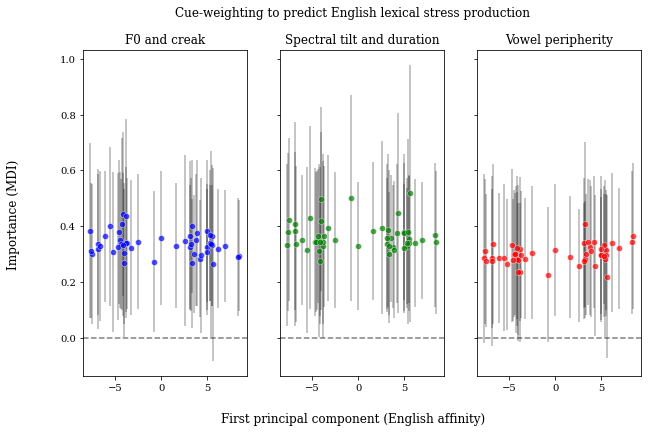

In [37]:
tex_fonts = {
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 12,
    "font.size": 10,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 10,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10
}
plt.rcParams.update(tex_fonts)

fig, axes = plt.subplots(1,3,
                         sharey = True, sharex = True, figsize = (10,6))
plt.subplots_adjust(hspace = 0.3)
sns.scatterplot(ax = axes[0], x = f0_creak.pc1,
                y = f0_creak['Importance (MDI)'], alpha = 0.7, color = "blue")

axes[0].errorbar(f0_creak.pc1, f0_creak['Importance (MDI)'],
                 yerr=f0_creak.Stdx2,
                 fmt=' ', zorder=-1, alpha = 0.3, color = "black")
axes[0].axhline(y = 0, color = "black", linestyle = "--", alpha = 0.5)
axes[0].set_title("F0 and creak")

axes[1].axhline(y = 0, color = "black", linestyle = "--", alpha = 0.5)
axes[1].set_title("Spectral tilt and duration")
axes[2].axhline(y = 0, color = "black", linestyle = "--", alpha = 0.5)
axes[2].set_title("Vowel peripherity")
sns.scatterplot(ax = axes[1], x = spec_dur.pc1,
                y = spec_dur['Importance (MDI)'], alpha = 0.7, color = "green")
axes[1].errorbar(spec_dur.pc1, spec_dur['Importance (MDI)'],
                 yerr=spec_dur.Stdx2,
                 fmt=' ', zorder=-1, alpha = 0.3, color = "black")

sns.scatterplot(ax = axes[2], x = vowel_periph.pc1,
                y = vowel_periph['Importance (MDI)'], alpha = 0.7, color = "red")
axes[2].errorbar(vowel_periph.pc1, vowel_periph['Importance (MDI)'],
                 yerr=vowel_periph.Stdx2,
                 fmt=' ', zorder=-1, alpha = 0.3, color = "black")

 
# axes[0,0].set_xticklabels(['', '', ''])
axes[0].set_xlabel("")
axes[1].set_xlabel("")
axes[2].set_xlabel("")

axes[0].set_ylabel("")
axes[1].set_ylabel("")
axes[2].set_ylabel("")
fig.supxlabel("First principal component (English affinity)")
fig.supylabel("Importance (MDI)")
fig.suptitle("Cue-weighting to predict English lexical stress production")


# plt.ylim([-1.5,4.5])
# plt.savefig('figures/eng_importance_pc1.jpg', format='jpg', dpi = 800)
plt.show();

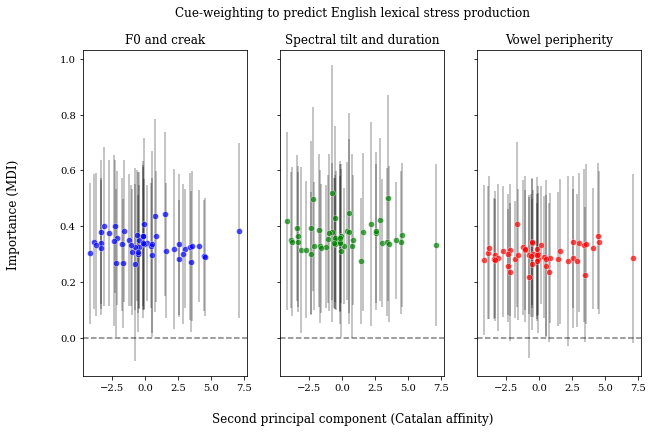

In [38]:
tex_fonts = {
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 12,
    "font.size": 10,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 10,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10
}
plt.rcParams.update(tex_fonts)

fig, axes = plt.subplots(1,3,
                         sharey = True, sharex = True, figsize = (10,6))
plt.subplots_adjust(hspace = 0.3)
sns.scatterplot(ax = axes[0], x = f0_creak.pc2,
                y = f0_creak['Importance (MDI)'], alpha = 0.7, color = "blue")

axes[0].errorbar(f0_creak.pc2, f0_creak['Importance (MDI)'],
                 yerr=f0_creak.Stdx2,
                 fmt=' ', zorder=-1, alpha = 0.3, color = "black")
axes[0].axhline(y = 0, color = "black", linestyle = "--", alpha = 0.5)
axes[0].set_title("F0 and creak")

axes[1].axhline(y = 0, color = "black", linestyle = "--", alpha = 0.5)
axes[1].set_title("Spectral tilt and duration")
axes[2].axhline(y = 0, color = "black", linestyle = "--", alpha = 0.5)
axes[2].set_title("Vowel peripherity")
sns.scatterplot(ax = axes[1], x = spec_dur.pc2,
                y = spec_dur['Importance (MDI)'], alpha = 0.7, color = "green")
axes[1].errorbar(spec_dur.pc2, spec_dur['Importance (MDI)'],
                 yerr=spec_dur.Stdx2,
                 fmt=' ', zorder=-1, alpha = 0.3, color = "black")

sns.scatterplot(ax = axes[2], x = vowel_periph.pc2,
                y = vowel_periph['Importance (MDI)'], alpha = 0.7, color = "red")
axes[2].errorbar(vowel_periph.pc2, vowel_periph['Importance (MDI)'],
                 yerr=vowel_periph.Stdx2,
                 fmt=' ', zorder=-1, alpha = 0.3, color = "black")

 
# axes[0,0].set_xticklabels(['', '', ''])
axes[0].set_xlabel("")
axes[1].set_xlabel("")
axes[2].set_xlabel("")

axes[0].set_ylabel("")
axes[1].set_ylabel("")
axes[2].set_ylabel("")
fig.supxlabel("Second principal component (Catalan affinity)")
fig.supylabel("Importance (MDI)")
fig.suptitle("Cue-weighting to predict English lexical stress production")


# plt.ylim([-1.5,4.5])
# plt.savefig('figures/eng_importance_pc1.jpg', format='jpg', dpi = 800)
plt.show();

In [39]:
spa = df[df['Language']=="spa"].copy()
f0_creak = spa[spa['Feature']=="f0_creak_ratio"].copy()
vowel_periph = spa[spa['Feature']=="vowel_periph_ratio"].copy()
spec_dur = spa[spa['Feature']=="spec_dur_ratio"].copy()

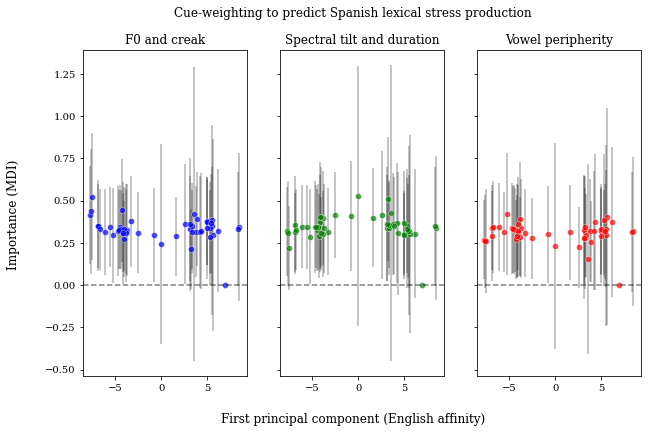

In [40]:
tex_fonts = {
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 12,
    "font.size": 10,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 10,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10
}
plt.rcParams.update(tex_fonts)

fig, axes = plt.subplots(1,3,
                         sharey = True, sharex = True, figsize = (10,6))
plt.subplots_adjust(hspace = 0.3)
sns.scatterplot(ax = axes[0], x = f0_creak.pc1,
                y = f0_creak['Importance (MDI)'], alpha = 0.7, color = "blue")

axes[0].errorbar(f0_creak.pc1, f0_creak['Importance (MDI)'],
                 yerr=f0_creak.Stdx2,
                 fmt=' ', zorder=-1, alpha = 0.3, color = "black")
axes[0].axhline(y = 0, color = "black", linestyle = "--", alpha = 0.5)
axes[0].set_title("F0 and creak")

axes[1].axhline(y = 0, color = "black", linestyle = "--", alpha = 0.5)
axes[1].set_title("Spectral tilt and duration")
axes[2].axhline(y = 0, color = "black", linestyle = "--", alpha = 0.5)
axes[2].set_title("Vowel peripherity")
sns.scatterplot(ax = axes[1], x = spec_dur.pc1,
                y = spec_dur['Importance (MDI)'], alpha = 0.7, color = "green")
axes[1].errorbar(spec_dur.pc1, spec_dur['Importance (MDI)'],
                 yerr=spec_dur.Stdx2,
                 fmt=' ', zorder=-1, alpha = 0.3, color = "black")

sns.scatterplot(ax = axes[2], x = vowel_periph.pc1,
                y = vowel_periph['Importance (MDI)'], alpha = 0.7, color = "red")
axes[2].errorbar(vowel_periph.pc1, vowel_periph['Importance (MDI)'],
                 yerr=vowel_periph.Stdx2,
                 fmt=' ', zorder=-1, alpha = 0.3, color = "black")

 
# axes[0,0].set_xticklabels(['', '', ''])
axes[0].set_xlabel("")
axes[1].set_xlabel("")
axes[2].set_xlabel("")

axes[0].set_ylabel("")
axes[1].set_ylabel("")
axes[2].set_ylabel("")
fig.supxlabel("First principal component (English affinity)")
fig.supylabel("Importance (MDI)")
fig.suptitle("Cue-weighting to predict Spanish lexical stress production")


# plt.ylim([-1.5,4.5])
# plt.savefig('figures/eng_importance_pc1.jpg', format='jpg', dpi = 800)
plt.show();

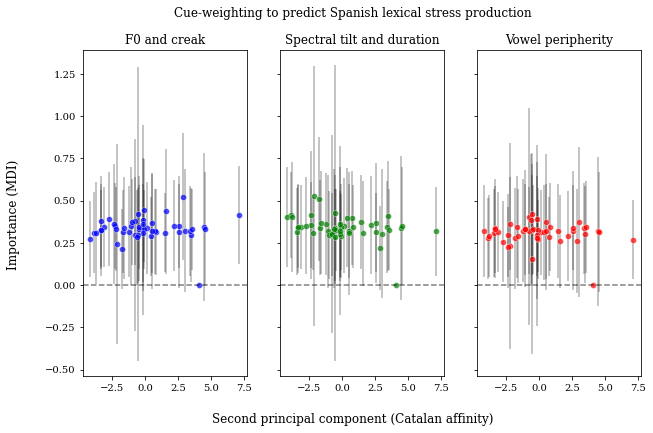

In [41]:
tex_fonts = {
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 12,
    "font.size": 10,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 10,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10
}
plt.rcParams.update(tex_fonts)

fig, axes = plt.subplots(1,3,
                         sharey = True, sharex = True, figsize = (10,6))
plt.subplots_adjust(hspace = 0.3)
sns.scatterplot(ax = axes[0], x = f0_creak.pc2,
                y = f0_creak['Importance (MDI)'], alpha = 0.7, color = "blue")

axes[0].errorbar(f0_creak.pc2, f0_creak['Importance (MDI)'],
                 yerr=f0_creak.Stdx2,
                 fmt=' ', zorder=-1, alpha = 0.3, color = "black")
axes[0].axhline(y = 0, color = "black", linestyle = "--", alpha = 0.5)
axes[0].set_title("F0 and creak")

axes[1].axhline(y = 0, color = "black", linestyle = "--", alpha = 0.5)
axes[1].set_title("Spectral tilt and duration")
axes[2].axhline(y = 0, color = "black", linestyle = "--", alpha = 0.5)
axes[2].set_title("Vowel peripherity")
sns.scatterplot(ax = axes[1], x = spec_dur.pc2,
                y = spec_dur['Importance (MDI)'], alpha = 0.7, color = "green")
axes[1].errorbar(spec_dur.pc2, spec_dur['Importance (MDI)'],
                 yerr=spec_dur.Stdx2,
                 fmt=' ', zorder=-1, alpha = 0.3, color = "black")

sns.scatterplot(ax = axes[2], x = vowel_periph.pc2,
                y = vowel_periph['Importance (MDI)'], alpha = 0.7, color = "red")
axes[2].errorbar(vowel_periph.pc2, vowel_periph['Importance (MDI)'],
                 yerr=vowel_periph.Stdx2,
                 fmt=' ', zorder=-1, alpha = 0.3, color = "black")

 
# axes[0,0].set_xticklabels(['', '', ''])
axes[0].set_xlabel("")
axes[1].set_xlabel("")
axes[2].set_xlabel("")

axes[0].set_ylabel("")
axes[1].set_ylabel("")
axes[2].set_ylabel("")
fig.supxlabel("Second principal component (Catalan affinity)")
fig.supylabel("Importance (MDI)")
fig.suptitle("Cue-weighting to predict Spanish lexical stress production")


# plt.ylim([-1.5,4.5])
# plt.savefig('figures/eng_importance_pc1.jpg', format='jpg', dpi = 800)
plt.show();

In [273]:
cat = df[df['Language']=="cat"].copy()
f0_creak = cat[cat['Feature']=="f0_creak_ratio"].copy()
vowel_periph = cat[cat['Feature']=="vowel_periph_ratio"].copy()
spec_dur = cat[cat['Feature']=="spec_dur_ratio"].copy()

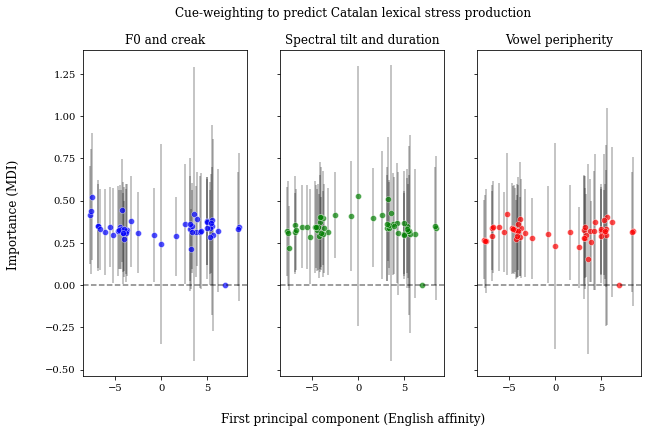

In [42]:
tex_fonts = {
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 12,
    "font.size": 10,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 10,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10
}
plt.rcParams.update(tex_fonts)

fig, axes = plt.subplots(1,3,
                         sharey = True, sharex = True, figsize = (10,6))
plt.subplots_adjust(hspace = 0.3)
sns.scatterplot(ax = axes[0], x = f0_creak.pc1,
                y = f0_creak['Importance (MDI)'], alpha = 0.7, color = "blue")

axes[0].errorbar(f0_creak.pc1, f0_creak['Importance (MDI)'],
                 yerr=f0_creak.Stdx2,
                 fmt=' ', zorder=-1, alpha = 0.3, color = "black")
axes[0].axhline(y = 0, color = "black", linestyle = "--", alpha = 0.5)
axes[0].set_title("F0 and creak")

axes[1].axhline(y = 0, color = "black", linestyle = "--", alpha = 0.5)
axes[1].set_title("Spectral tilt and duration")
axes[2].axhline(y = 0, color = "black", linestyle = "--", alpha = 0.5)
axes[2].set_title("Vowel peripherity")
sns.scatterplot(ax = axes[1], x = spec_dur.pc1,
                y = spec_dur['Importance (MDI)'], alpha = 0.7, color = "green")
axes[1].errorbar(spec_dur.pc1, spec_dur['Importance (MDI)'],
                 yerr=spec_dur.Stdx2,
                 fmt=' ', zorder=-1, alpha = 0.3, color = "black")

sns.scatterplot(ax = axes[2], x = vowel_periph.pc1,
                y = vowel_periph['Importance (MDI)'], alpha = 0.7, color = "red")
axes[2].errorbar(vowel_periph.pc1, vowel_periph['Importance (MDI)'],
                 yerr=vowel_periph.Stdx2,
                 fmt=' ', zorder=-1, alpha = 0.3, color = "black")

 
# axes[0,0].set_xticklabels(['', '', ''])
axes[0].set_xlabel("")
axes[1].set_xlabel("")
axes[2].set_xlabel("")

axes[0].set_ylabel("")
axes[1].set_ylabel("")
axes[2].set_ylabel("")
fig.supxlabel("First principal component (English affinity)")
fig.supylabel("Importance (MDI)")
fig.suptitle("Cue-weighting to predict Catalan lexical stress production")


# plt.ylim([-1.5,4.5])
# plt.savefig('figures/eng_importance_pc1.jpg', format='jpg', dpi = 800)
plt.show();

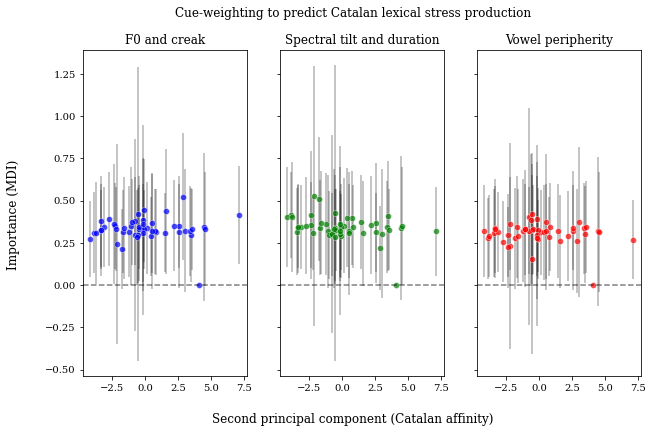

In [43]:
tex_fonts = {
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 12,
    "font.size": 10,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 10,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10
}
plt.rcParams.update(tex_fonts)

fig, axes = plt.subplots(1,3,
                         sharey = True, sharex = True, figsize = (10,6))
plt.subplots_adjust(hspace = 0.3)
sns.scatterplot(ax = axes[0], x = f0_creak.pc2,
                y = f0_creak['Importance (MDI)'], alpha = 0.7, color = "blue")

axes[0].errorbar(f0_creak.pc2, f0_creak['Importance (MDI)'],
                 yerr=f0_creak.Stdx2,
                 fmt=' ', zorder=-1, alpha = 0.3, color = "black")
axes[0].axhline(y = 0, color = "black", linestyle = "--", alpha = 0.5)
axes[0].set_title("F0 and creak")

axes[1].axhline(y = 0, color = "black", linestyle = "--", alpha = 0.5)
axes[1].set_title("Spectral tilt and duration")
axes[2].axhline(y = 0, color = "black", linestyle = "--", alpha = 0.5)
axes[2].set_title("Vowel peripherity")
sns.scatterplot(ax = axes[1], x = spec_dur.pc2,
                y = spec_dur['Importance (MDI)'], alpha = 0.7, color = "green")
axes[1].errorbar(spec_dur.pc2, spec_dur['Importance (MDI)'],
                 yerr=spec_dur.Stdx2,
                 fmt=' ', zorder=-1, alpha = 0.3, color = "black")

sns.scatterplot(ax = axes[2], x = vowel_periph.pc2,
                y = vowel_periph['Importance (MDI)'], alpha = 0.7, color = "red")
axes[2].errorbar(vowel_periph.pc2, vowel_periph['Importance (MDI)'],
                 yerr=vowel_periph.Stdx2,
                 fmt=' ', zorder=-1, alpha = 0.3, color = "black")

 
# axes[0,0].set_xticklabels(['', '', ''])
axes[0].set_xlabel("")
axes[1].set_xlabel("")
axes[2].set_xlabel("")

axes[0].set_ylabel("")
axes[1].set_ylabel("")
axes[2].set_ylabel("")
fig.supxlabel("Second principal component (Catalan affinity)")
fig.supylabel("Importance (MDI)")
fig.suptitle("Cue-weighting to predict Catalan lexical stress production")


# plt.ylim([-1.5,4.5])
# plt.savefig('figures/eng_importance_pc1.jpg', format='jpg', dpi = 800)
plt.show();

## Get visualization across language profile in English

In [44]:
df_wd.columns

Index(['partID', 'Language', 'stress_wd', 'f0_creak_ratio', 'spec_dur_ratio',
       'vowel_periph_ratio'],
      dtype='object')

In [45]:
df_wd_lang = pd.merge(df_wd, parts, on = "partID", how = "left")
df_wd_lang.head()

,partID,Language,stress_wd,f0_creak_ratio,spec_dur_ratio,vowel_periph_ratio,lang_profile
0,afs116,cat,Oxytone,0.586621,-0.455262,-0.308741,l1_eng
1,afs116,cat,Oxytone,0.885033,0.593714,429.248250,l1_eng
2,afs116,cat,Oxytone,0.851287,0.856317,4.716789,l1_eng
3,afs116,cat,Oxytone,0.889843,0.920721,5.181689,l1_eng
4,afs116,cat,Oxytone,1.101281,0.628666,3.577419,l1_eng


In [46]:
eng_lang = df_wd_lang[df_wd_lang['Language']=="eng"].copy()

In [47]:
y_eng = eng_lang['stress_wd']
X_eng = eng_lang.drop(['stress_wd', 'Language', 'partID', 'lang_profile'], axis = 1)
    
rf_classifier = RandomForestClassifier(random_state = 10)
    
param_grid = { 
    'n_estimators': [500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : np.arange(4,10,1),
    'criterion' :['gini', 'entropy']
}

CV_rfc_eng = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv= 5)
CV_rfc_eng.fit(X_eng, y_eng)
    
print("Best RF Estimator: ", CV_rfc_eng.best_params_, "\n")
    
scores_eng = cross_val_score(rf_classifier, X_eng, y_eng.ravel(), cv=5)
print("Accuracy over all data: ", scores_eng.mean())
    
rf_classifier_best_eng = CV_rfc_eng.best_estimator_

cols_eng = X_eng.columns

Best RF Estimator:  {'criterion': 'entropy', 'max_depth': 9, 'max_features': 'auto', 'n_estimators': 500} 

Accuracy over all data:  0.5958104651162791


In [48]:
def rf_eng_lang(df, rf_classifier_best, cols):
    lang_profile = []
    stats_list = []
        
    for l in df.lang_profile.unique():
        data = df[df['lang_profile']==l].copy()
        data.drop(['Language', 'partID', 'lang_profile'], axis = 1, inplace = True)
            
        # define predictor label
        y = data['stress_wd']

        # define feature set
        X = data.drop(['stress_wd'], axis = 1)
            
        rf_classifier_best.fit(X, y.ravel())
        stats = cbook.boxplot_stats(np.vstack([tree.feature_importances_ for tree in rf_classifier_best.estimators_]),
                    labels=cols, bootstrap=10000)
        
        stats_list.append(stats)
        lang_profile.append(l)
        
    return(lang_profile, stats_list)

In [49]:
lang_profile_list, stats_list = rf_eng_lang(eng_lang, rf_classifier_best_eng, cols_eng)

In [50]:
lang_profile_list

['l1_eng', 'l3_eng', 'mono']

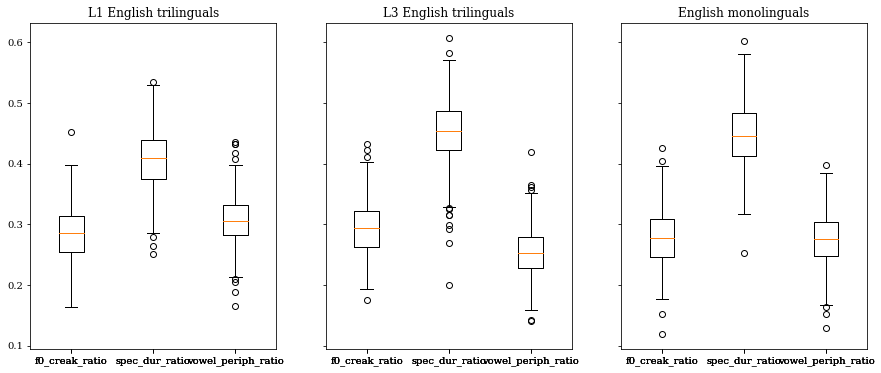

<Figure size 432x288 with 0 Axes>

In [53]:
fig, ax = plt.subplots(1, 3, figsize = (15,6), sharey = True, sharex = True)
ax[0].bxp(stats_list[0])
ax[1].bxp(stats_list[1])
ax[2].bxp(stats_list[2])
ax[0].set_title("L1 English trilinguals")
ax[1].set_title("L3 English trilinguals")
ax[2].set_title("English monolinguals")
# ax.set_title("Feature importances for L1 English trilinguals")
# ax.set_ylabel("Decrease in impurity")
# ax.set_ylim(-0.05,1)
plt.figure();